In [1]:
import sys
import tensorflow as tf
import numpy as np
from google.colab import drive
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/CommonSwissBirds

/content/drive/MyDrive/CommonSwissBirds


In [4]:
%ls

01_data_prep/   04_resnet_50/         07_VGG16/                readme.ipynb
02_data/        05_efficientNetV2L/   08_custom_CNN/           utils/
03_base_model/  06_mobileNetV3_mini/  09_VGG16_original_head/


In [5]:
sys.path.append('./utils')
import utils

In [6]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-0c5419ce-1616-144d-a4f8-71333d2294ad)


In [7]:
class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/test_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
)

Found 1222 files belonging to 10 classes.


In [11]:
showcase_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/showcase_images',
    labels='inferred',
    label_mode='categorical',
    class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube'],
    color_mode='rgb',
    shuffle=False,
    batch_size=30,
    image_size=(224, 224),
)

Found 30 files belonging to 10 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
showcase_ds = showcase_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
base_model = EfficientNetV2L(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)

473176280/473176280 [==============================] - 2s 0us/step


In [14]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./05_efficientNetV2L/model/best.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [15]:
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks],
)

Epoch 1/50
125/125 [==============================] - 143s 840ms/step - loss: 0.4807 - accuracy: 0.8435 - val_loss: 0.2289 - val_accuracy: 0.9240
Epoch 2/50
125/125 [==============================] - 19s 155ms/step - loss: 0.1667 - accuracy: 0.9448 - val_loss: 0.1607 - val_accuracy: 0.9510
Epoch 3/50
125/125 [==============================] - 21s 171ms/step - loss: 0.1031 - accuracy: 0.9670 - val_loss: 0.1369 - val_accuracy: 0.9520
Epoch 4/50
125/125 [==============================] - 20s 161ms/step - loss: 0.0885 - accuracy: 0.9703 - val_loss: 0.1265 - val_accuracy: 0.9570
Epoch 5/50
125/125 [==============================] - 20s 161ms/step - loss: 0.0683 - accuracy: 0.9760 - val_loss: 0.1103 - val_accuracy: 0.9700
Epoch 6/50
125/125 [==============================] - 14s 109ms/step - loss: 0.0516 - accuracy: 0.9833 - val_loss: 0.1680 - val_accuracy: 0.9530
Epoch 7/50
125/125 [==============================] - 14s 109ms/step - loss: 0.0485 - accuracy: 0.9860 - val_loss: 0.1564 - val_a

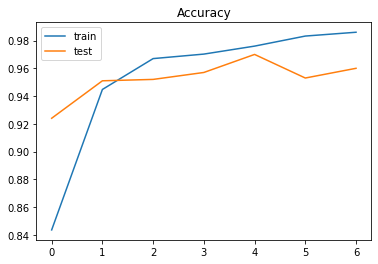

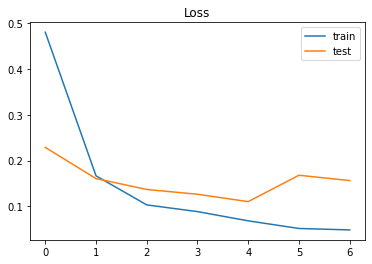

In [16]:
%matplotlib inline
utils.plot_history(history)

In [17]:
# Possible to start here without training... just loading the new weights...
base_model = EfficientNetV2L(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)
model.load_weights('./05_efficientNetV2L/model/best.h5')

In [18]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
39/39 [==============================] - 34s 613ms/step - loss: 0.2172 - accuracy: 0.9501
test loss, test acc: [0.21724997460842133, 0.9500818252563477]


In [19]:
testset_predictions = model.predict(test_ds)
predicted_labels = [prediction.argmax() for prediction in testset_predictions]
true_labels = utils.get_labels_from_categorical_batch_dataset(test_ds)
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

39/39 [==============================] - 9s 79ms/step


In [20]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       0.97      0.94      0.95       113
     blaumeise       0.93      0.90      0.91       125
      buchfink       0.93      0.98      0.96       125
        elster       0.95      1.00      0.97       113
hausrotschwanz       0.93      0.97      0.95       117
     hausspatz       0.98      0.90      0.94       133
     kohlmeise       0.90      0.97      0.93       125
   rabenkraehe       1.00      0.98      0.99       121
          star       0.94      0.93      0.94       125
  tuerkentaube       0.98      0.95      0.96       125

      accuracy                           0.95      1222
     macro avg       0.95      0.95      0.95      1222
  weighted avg       0.95      0.95      0.95      1222



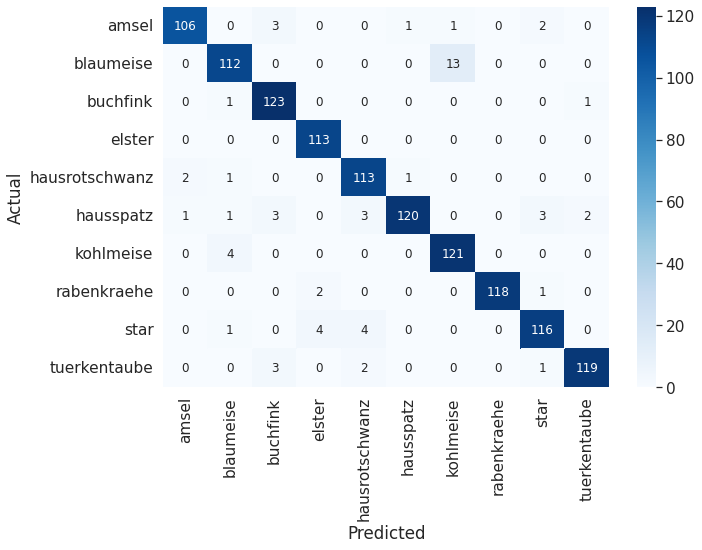

In [21]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

In [22]:
showcase_predictions = model.predict(showcase_ds)
predicted_labels = [prediction.argmax() for prediction in showcase_predictions]
true_labels = utils.get_labels_from_categorical_batch_dataset(showcase_ds)
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

1/1 [==============================] - 1s 1s/step


In [23]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       1.00      1.00      1.00         3
     blaumeise       1.00      1.00      1.00         3
      buchfink       1.00      1.00      1.00         3
        elster       1.00      1.00      1.00         3
hausrotschwanz       1.00      1.00      1.00         3
     hausspatz       1.00      1.00      1.00         3
     kohlmeise       1.00      1.00      1.00         3
   rabenkraehe       1.00      1.00      1.00         3
          star       1.00      1.00      1.00         3
  tuerkentaube       1.00      1.00      1.00         3

      accuracy                           1.00        30
     macro avg       1.00      1.00      1.00        30
  weighted avg       1.00      1.00      1.00        30



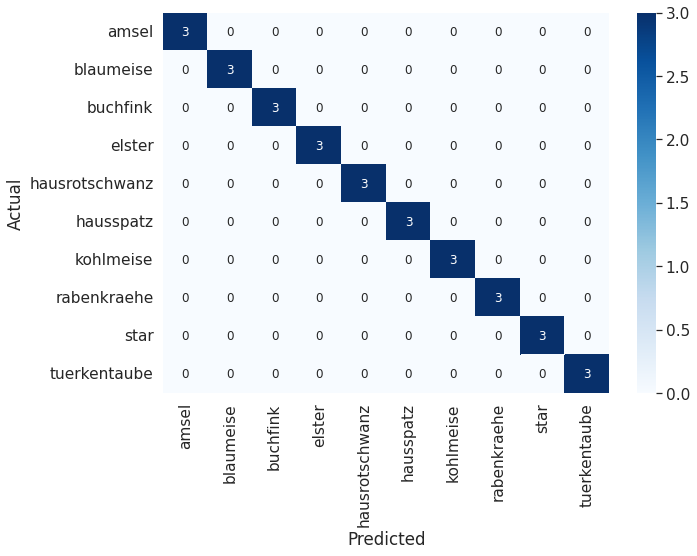

In [24]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

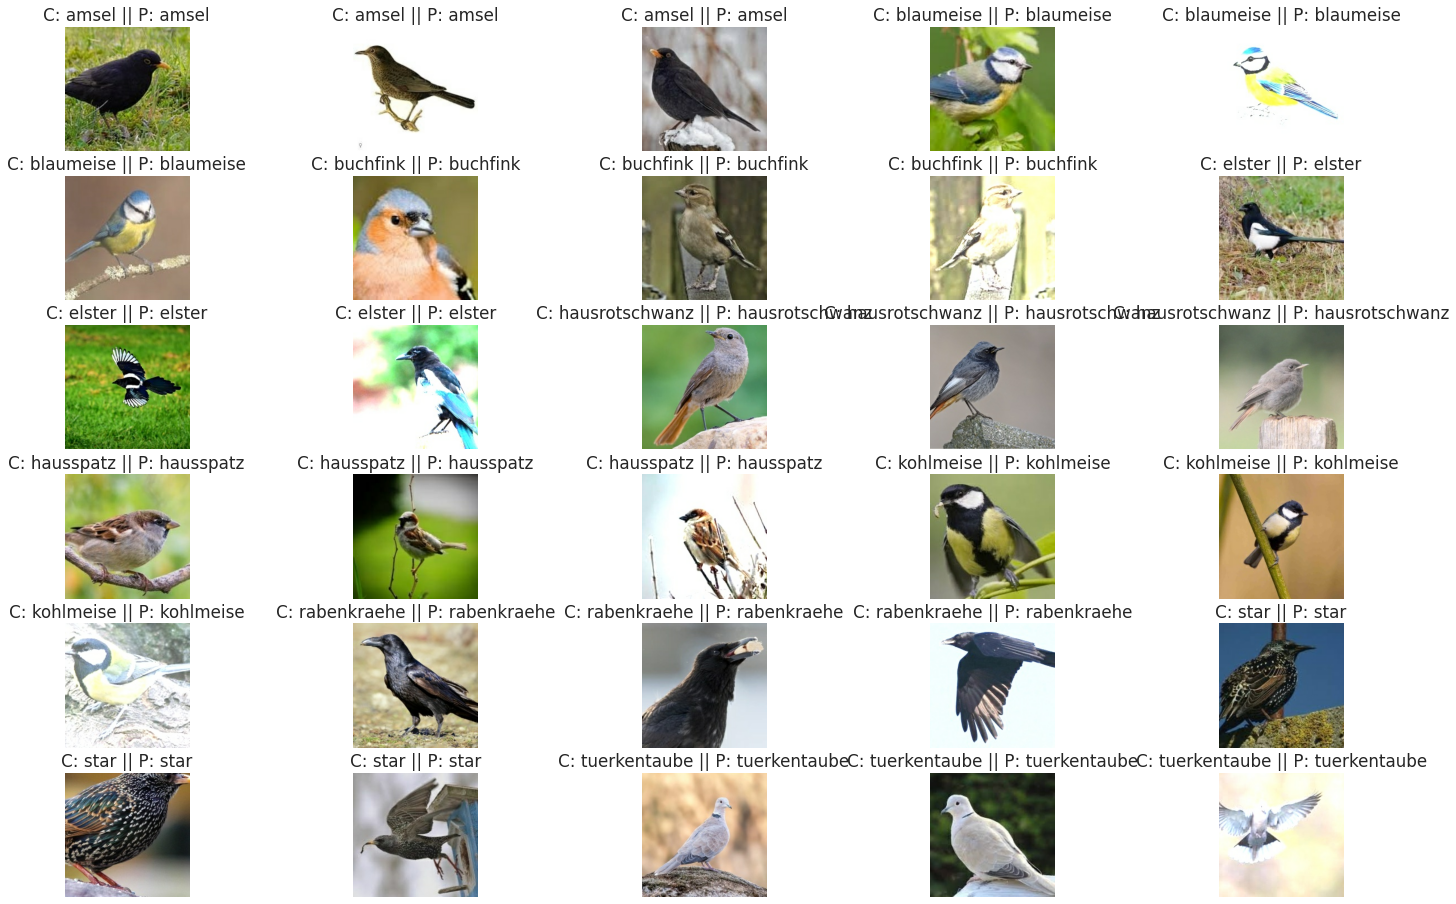

In [25]:
%matplotlib inline
utils.plot_showcase_categorical(showcase_ds, class_names, showcase_predictions)

# Grad-CAM
Showing important features of the image

Remarkable: It seems to look at many more details than mobilenet for example. That makes sense...

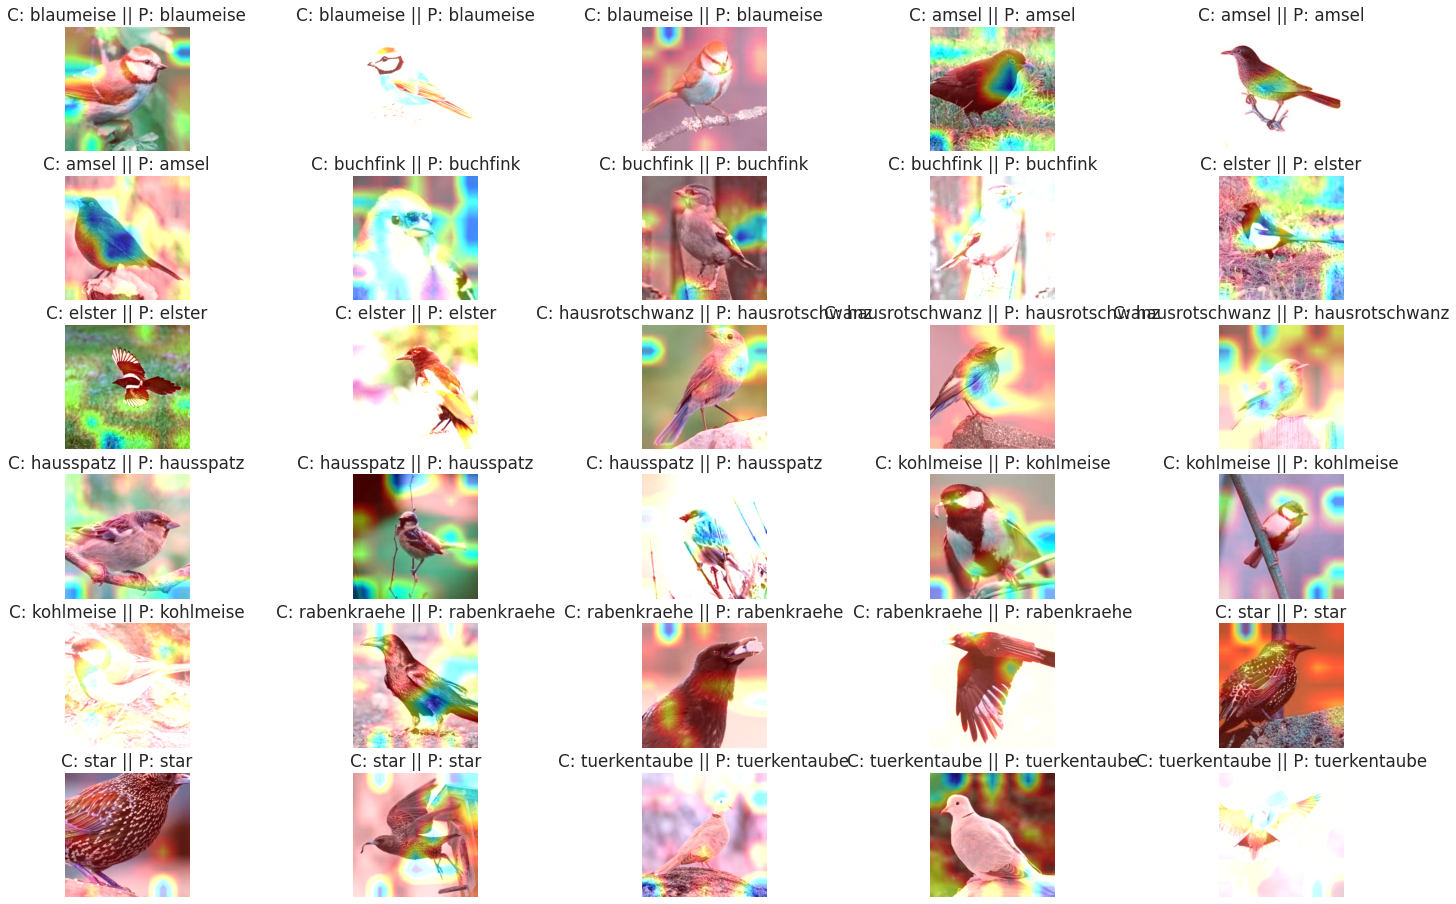

In [26]:
showcase_path = './02_data/99_dataset_preparation/showcase_images'
last_convolution_layer_name = 'block6x_project_conv'
utils.plot_showcase_gradcam_overlay(showcase_path, class_names, model, last_convolution_layer_name)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['rescaling_1[0][0]']            
                                32)                                                         